In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import pie_plot
import numpy as np
import prince


In [2]:
df = pd.read_csv('../data/raw/PS_20174392719_1491204439457_log.csv')

# Basic overview

In [3]:
print(f'This dataset contains {df.shape[0]} samples and {df.shape[1]} features')

This dataset contains 6362620 samples and 11 features


In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Observations:

- Step: based on the mean and the std deviation, the distribution seems quite uniform.

- Amount: there is an enormous variation of amount of transferred money and the standard deviation is very high (603.858). 
50% of all transactions move below 74.872, 75% of all transactions move below 208.721 and the max amount is 92.445.200 so we will find very few but huge transactions (long tail).

- OldbalanceOrg, NewbalanceOrig, OldbalanceDest and NewbalanceDest: both have similar standard deviations and maximum values. It calls my attention that min, 25% and even 50% can be 0. That makes me wonder if those accounts have been opened or closed just to commit fraud. Some significant amount accounts have also completely completely emptied. 

- isFraud: the mean is very close to zero so we can expect the labels of fraudulent transactions are going to be rare and the dataset unbalanced. 

- isFlaggedFraud: the mean is even lower but we have to take into consideration that this flag is activated only for transactions greater than 200.000. 

In [7]:
df.describe(include = ['O'])

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1530544995,C1286084959
freq,2237500,3,113


Observations:

- Type: there are 5 types of transactions, the most frequent is CASH_OUT. We will analyse them and their relationship with fraudulent transactions.

- nameOrig and nameDest: some names are repeated. We will check if that has something to do with fraudulent behaviours. 

In [8]:
df.loc[df.duplicated()]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


# Data preparation

In [9]:
df['type'] = df['type'].astype('category')

In [10]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [11]:
df = df.rename(columns={'oldbalanceOrg': 'oldbalanceOrig'})
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


We won't use the column 'isFlaggedFraud' for now

In [13]:
data = df[['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrig', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].copy()

data.to_csv('../data/processed/fraud_viz_df.csv', index= False)

# Visualization of variables

### Target variable: isFraud

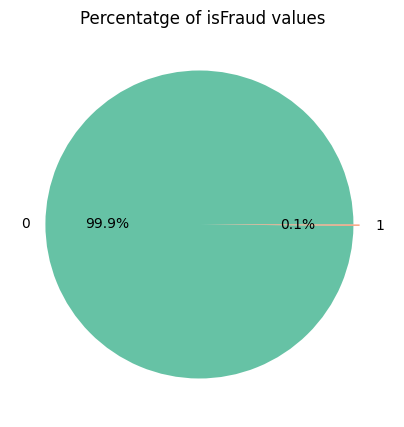

In [13]:
pie_plot(data['isFraud'])


In [14]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

This is an very imbalanced dataset

## Univariate analysis

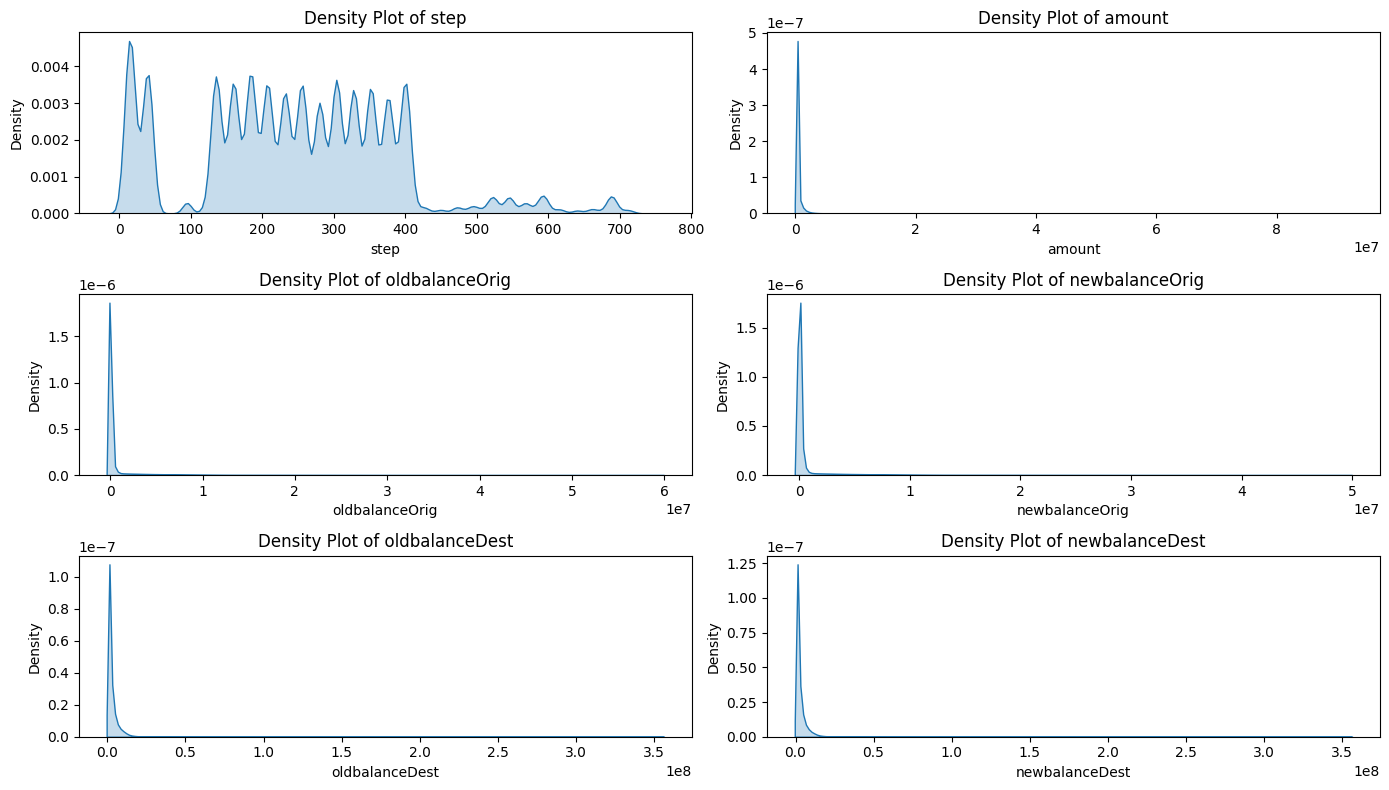

In [15]:
numeric_cols =['step', 'amount','oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest','newbalanceDest']


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,8))
axes = axes.flatten()  

for ax, col in zip(axes, numeric_cols):
    sns.kdeplot(data[col], ax=ax, fill=True)
    ax.set_title(f'Density Plot of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

### Step

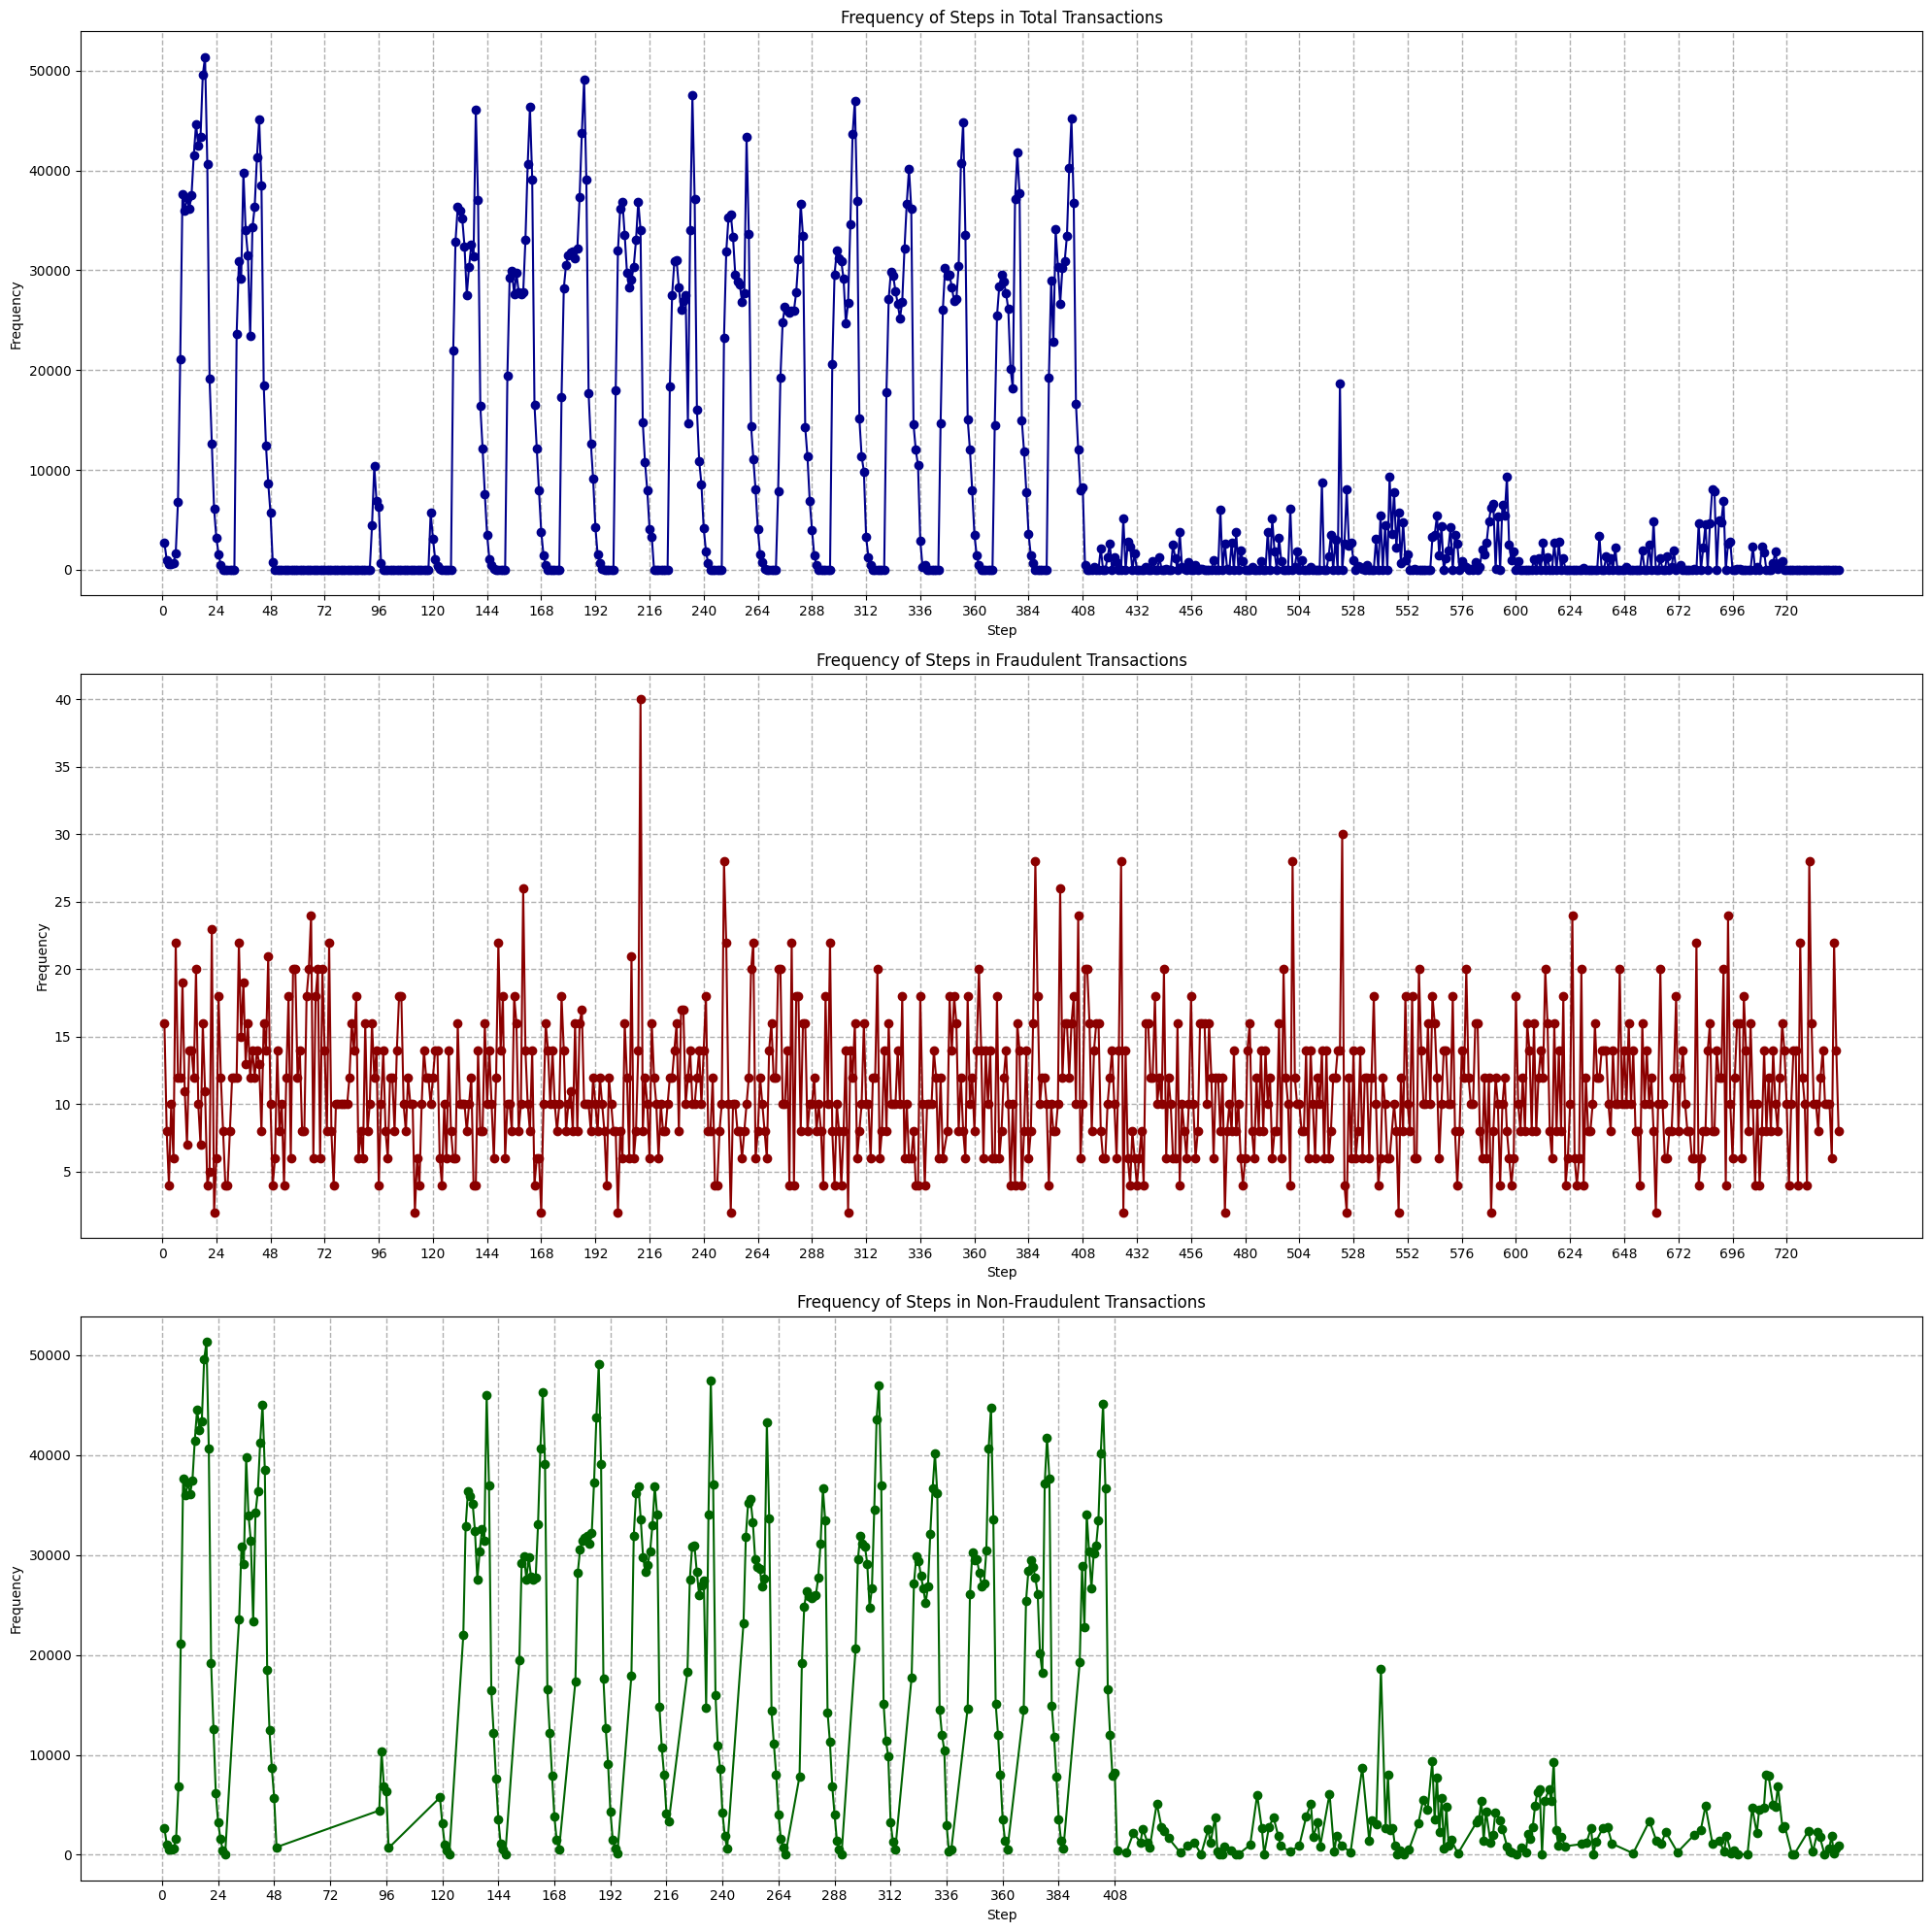

In [16]:
total_value_counts = data['step'].value_counts().sort_index()
fraud_value_counts = data[data['isFraud'] == 1]['step'].value_counts().sort_index()
non_fraud_value_counts = data[data['isFraud'] == 0]['step'].value_counts().sort_index()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))

for ax, counts, title, color in zip(axes, [total_value_counts, fraud_value_counts, non_fraud_value_counts], 
                                    ["Frequency of Steps in Total Transactions", 
                                     "Frequency of Steps in Fraudulent Transactions", 
                                     "Frequency of Steps in Non-Fraudulent Transactions"], 
                                    ['#00008B', '#8B0000', '#006400']):
    ax.plot(counts.index, counts, marker='o', color=color)
    ax.set_title(title)
    ax.set_xlabel("Step")
    ax.set_ylabel("Frequency")
    ax.grid(which='both', linestyle='--', linewidth=1)
    ax.set_xticks(np.arange(0, len(counts) + 1, 24)) 
    
plt.tight_layout()
plt.show()

Observations:

For context, 1 step represents 1 hour. The total range of hour data is equivalent to a month. 

There is a clear pattern that differentiates the behaviour between the fraudulent and the non-fraudulent transactions. 

Non-fraudulent transactions happen inside defined step ranges and slow down when the step is a bit higher than 400 (15 days aprox). This behaviour makes sense since people get their salaries at the beginning of the month. The is a gap between the first 48 and 120 hours. It would be interesting to get more information about the month, year, country from where the transaction was sent/received. Was it a public holiday? 

Fraudulent transactions stay constant along the step range. That means fraudsters behaviour stays constant all over the month. 

Fraudsters usually take very short time to process the transaction so it would be also nice to obtain data about the amount of time spent on the merchants website, the time used by the client to confirm the transaction (short times can indicate that a bot is actually using the platform), etc.

### Type

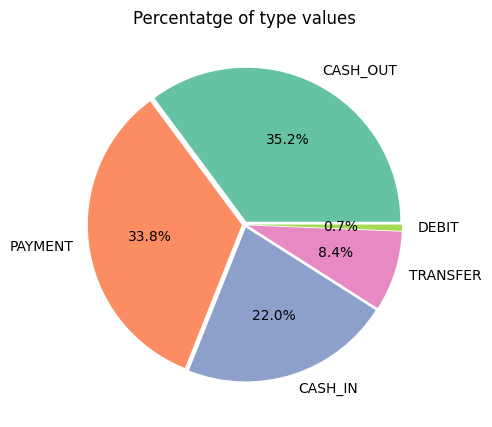

In [17]:
pie_plot(data['type'])

In [18]:
# Which are fraud among every category
fraud_types = df.groupby(['type', 'isFraud'], observed=True).size().reset_index(name='count')
total_transactions = fraud_types.groupby('type', observed = True)['count'].sum().reset_index(name='total')
desc_types = fraud_types.merge(total_transactions, on='type')

desc_types['percentage (%)'] = (desc_types['count'] / desc_types['total'])*100
desc_types.query('isFraud == 1')

,type,isFraud,count,total,percentage (%)
2,CASH_OUT,1,4116,2237500,0.183955
6,TRANSFER,1,4097,532909,0.768799


Observations: 

Fraud happens in two types of transactions: CASH_OUT and TRANSFER.

CASH_OUT fraud is mostly made by card clonation inside the ATM (it happened to me once). Improving security systems on ATM in order to avoid the easy installation of cloning devices inside them is a very important field to improve safety with card usage.

TRANSFER can be done using the data cloned from the ATM. Security or confirmation warnings sent by the bank app or via e-mail when there is a strange behaviour in your usage would help a lot in avoiding such cases. Nowadays scammers improved their strategies so much that they scam people pretending they call you from your bank or any other trustworthy institution and convince you to transfer money to their accounts. 

These cases are among many other but I considered them worth to mention some examples of the types of transactions that we are seeing in this dataset.

### Amount

I use exponential increasing bins since the range of my data is high. Further analysis can give some insights using uniform bins

In [19]:
bins = [0, 1000, 10000, 100000, 1000000, 10000000, 100000000]
labels = ['0-1.000', '1.000-10.000', '10.000-100.000', '100.000-1.000.000', '1.000.000-10.000.000', '10.000.000-100.000.000']
data['amount_range'] = pd.cut(data['amount'], bins=bins, labels=labels, right=False)

### Distribution of the new variable amount_range

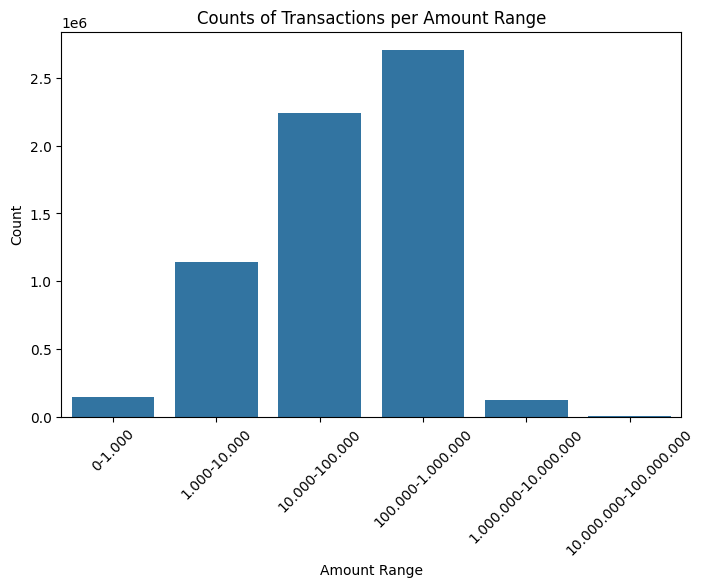

In [20]:
order = ['0-1.000', '1.000-10.000', '10.000-100.000', '100.000-1.000.000', '1.000.000-10.000.000', '10.000.000-100.000.000']


plt.figure(figsize=(8, 5))
barplot = sns.countplot(data=data, x='amount_range', order=order)

plt.title('Counts of Transactions per Amount Range')
plt.xlabel('Amount Range')
plt.ylabel('Count')

plt.xticks(rotation=45)  
plt.show()


In [21]:
count_data = data.groupby(['amount_range', 'isFraud'], observed=True).size().reset_index(name='count')
total_transactions = count_data.groupby('amount_range', observed = True)['count'].sum().reset_index(name='total')
desc_amount = count_data.merge(total_transactions, on='amount_range')
desc_amount['rate (%)'] = (desc_amount['count'] / desc_amount['total'])*100
desc_amount.query('isFraud == 1') 

,amount_range,isFraud,count,total,rate (%)
1,0-1.000,1,58,142642,0.040661
3,1.000-10.000,1,220,1143361,0.019242
5,10.000-100.000,1,1429,2239253,0.063816
7,100.000-1.000.000,1,3800,2706738,0.140390
9,1.000.000-10.000.000,1,2419,124976,1.935572
11,10.000.000-100.000.000,1,287,5650,5.079646


Observations: 

The biggest ranges have a higher fraud_rate
- 100.000-1.000.000 = 0.14 % (most transactions are inside this amount range)
- 1.000.000-10.000.000 = 1.93 % (very scarce type of amount range)
- 10.000.000-100.000.000 = 5.07% (the less common and largest of all amount ranges)

Fraud is more likely to happen when huge amounts of money are transferred.

In [22]:
null_amount_orig = data.query('amount == 0').sort_values(by = 'nameOrig').reset_index()
print(f' Total amount of accounts that withdrew no money is : {len(null_amount_orig)}')
null_amount_orig 

 Total amount of accounts that withdrew no money is : 16


,index,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range
0,6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,0-1.000
1,5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0-1.000
2,6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,0-1.000
3,6351226,702,CASH_OUT,0.0,C1461113533,0.0,0.0,C1382150537,107777.02,107777.02,1,0-1.000
4,2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,0-1.000
5,6296015,671,CASH_OUT,0.0,C1960007029,0.0,0.0,C459118517,27938.72,27938.72,1,0-1.000
6,6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,0-1.000
7,6281485,646,CASH_OUT,0.0,C1997645312,0.0,0.0,C601248796,0.00,0.00,1,0-1.000
8,6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,0-1.000
9,6362463,730,CASH_OUT,0.0,C2088151490,0.0,0.0,C1156763710,0.00,0.00,1,0-1.000


Observations:

Fraudsters have been trying to withdraw money from empty accounts. None of them is repeated. Further information about, for example, the account age could help us identify some hidden pattern.

Is there any characteristic in those origin accounts we can find?

In [23]:
nameOrig_list = null_amount_orig['nameOrig'].tolist()

fraud_accounts = data[data['nameOrig'].isin(nameOrig_list)].reset_index()
print(f' Total amount of accounts that withdrew no money is : {len(fraud_accounts)}')
fraud_accounts

 Total amount of accounts that withdrew no money is : 16


,index,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range
0,2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,0-1.000
1,3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.00,0.00,1,0-1.000
2,3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1,0-1.000
3,5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0-1.000
4,5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1,0-1.000
5,5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2921531.34,2921531.34,1,0-1.000
6,6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,0-1.000
7,6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,0-1.000
8,6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,0-1.000
9,6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,0-1.000


These accounts have only been used to withdraw money fraudulently

### Balances in origin

In [24]:
subset_orig = df[[ 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'isFraud']].copy()
subset_orig['diffBalanceOrig'] = (subset_orig['oldbalanceOrig'] - subset_orig['newbalanceOrig']).round(2)


In [25]:
fraud_subset_orig = subset_orig.query('isFraud == 1').copy().reset_index(drop = True)
corr_fraud_subset_orig = fraud_subset_orig.drop(columns = 'isFraud').corr()
corr_fraud_subset_orig

,amount,oldbalanceOrig,newbalanceOrig,diffBalanceOrig
amount,1.000000,0.858859,0.338561,0.993904
oldbalanceOrig,0.858859,1.000000,0.767811,0.850741
newbalanceOrig,0.338561,0.767811,1.000000,0.316478
diffBalanceOrig,0.993904,0.850741,0.316478,1.000000


In [26]:
non_fraud_subset_orig = subset_orig.query('isFraud == 0').copy().reset_index(drop = True)
corr_non_fraud_subset_orig = non_fraud_subset_orig.drop(columns = 'isFraud').corr()
corr_non_fraud_subset_orig

,amount,oldbalanceOrig,newbalanceOrig,diffBalanceOrig
amount,1.000000,-0.009092,-0.008521,-0.012479
oldbalanceOrig,-0.009092,1.000000,0.999417,-0.340197
newbalanceOrig,-0.008521,0.999417,1.000000,-0.372112
diffBalanceOrig,-0.012479,-0.340197,-0.372112,1.000000


Observations: 

fraud_subset_orig shows high correlation between amount and oldbalanceOrig with diffBalanceOrig. Fraudsters try to extract the whole amount of money that users have inside the account. That could be a nice flag. 

non_fraud_subset_orig confirms that this behaviour doesn't appear on legitimate transactions. The NaN values of isFlaggedFraud just show that there is no variability in the results so the previous model works very well not giving False Positives

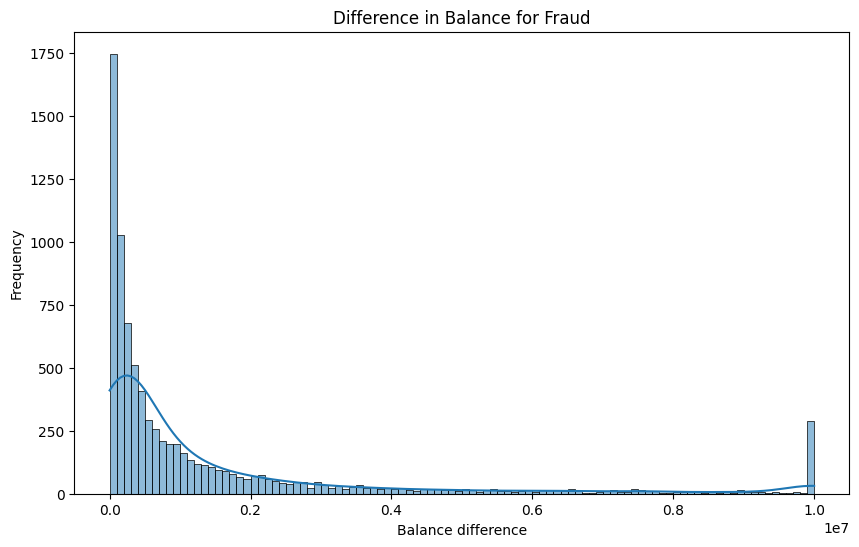

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(fraud_subset_orig['diffBalanceOrig'], bins=100, kde=True)
plt.title('Difference in Balance for Fraud')
plt.xlabel('Balance difference')
plt.ylabel('Frequency')
plt.show()

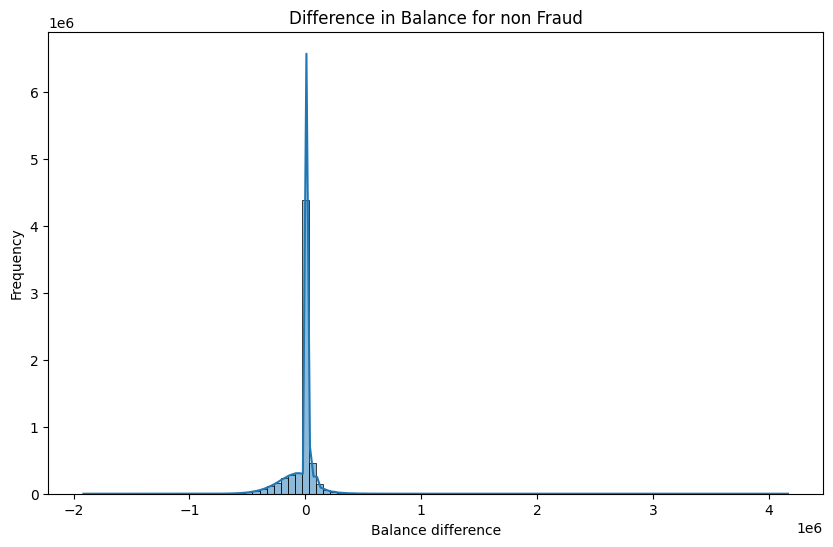

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(non_fraud_subset_orig['diffBalanceOrig'], bins=100, kde=True)
plt.title('Difference in Balance for non Fraud')
plt.xlabel('Balance difference')
plt.ylabel('Frequency')
plt.show()

### Balances in destination

In [29]:
subset_dest = df[[ 'amount', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']].copy()
subset_dest['diffBalanceDest'] = (subset_dest['newbalanceDest'] - subset_dest['oldbalanceDest']).round(2)


In [30]:
fraud_subset_dest = subset_dest.query('isFraud == 1').copy().reset_index(drop = True)
corr_fraud_subset_dest = fraud_subset_dest.drop(columns = 'isFraud').corr()
corr_fraud_subset_dest

,amount,oldbalanceDest,newbalanceDest,isFlaggedFraud,diffBalanceDest
amount,1.000000,-0.007037,0.299403,0.062365,0.642864
oldbalanceDest,-0.007037,1.000000,0.880353,-0.007207,0.056390
newbalanceDest,0.299403,0.880353,1.000000,-0.014465,0.523208
isFlaggedFraud,0.062365,-0.007207,-0.014465,1.000000,-0.017499
diffBalanceDest,0.642864,0.056390,0.523208,-0.017499,1.000000


In [31]:
non_fraud_subset_dest = subset_dest.query('isFraud == 0').copy().reset_index(drop = True)
corr_non_fraud_subset_dest = non_fraud_subset_dest.drop(columns = 'isFraud').corr()
corr_non_fraud_subset_dest

,amount,oldbalanceDest,newbalanceDest,isFlaggedFraud,diffBalanceDest
amount,1.000000,0.298774,0.464114,NaN,0.850764
oldbalanceDest,0.298774,1.000000,0.976723,NaN,0.233333
newbalanceDest,0.464114,0.976723,1.000000,NaN,0.436486
isFlaggedFraud,NaN,NaN,NaN,NaN,NaN
diffBalanceDest,0.850764,0.233333,0.436486,NaN,1.000000


Observations:

In this case the variable amount is the most correlated to the difference in balances. More research could be done here since there must be some missing data because balances in the origin and the destination don't match so that would mean there is some sort of by-pass that sends the money somewhere else? 

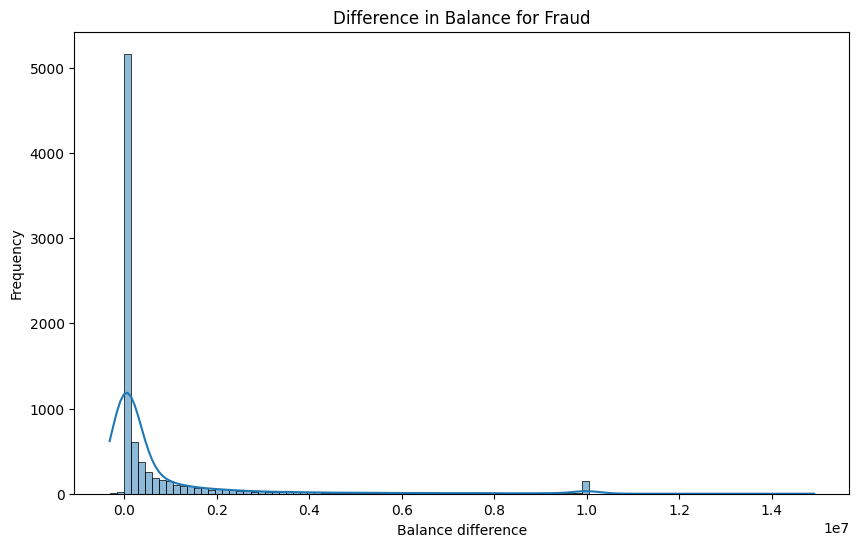

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(fraud_subset_dest['diffBalanceDest'], bins=100, kde=True)
plt.title('Difference in Balance for Fraud')
plt.xlabel('Balance difference')
plt.ylabel('Frequency')
plt.show()

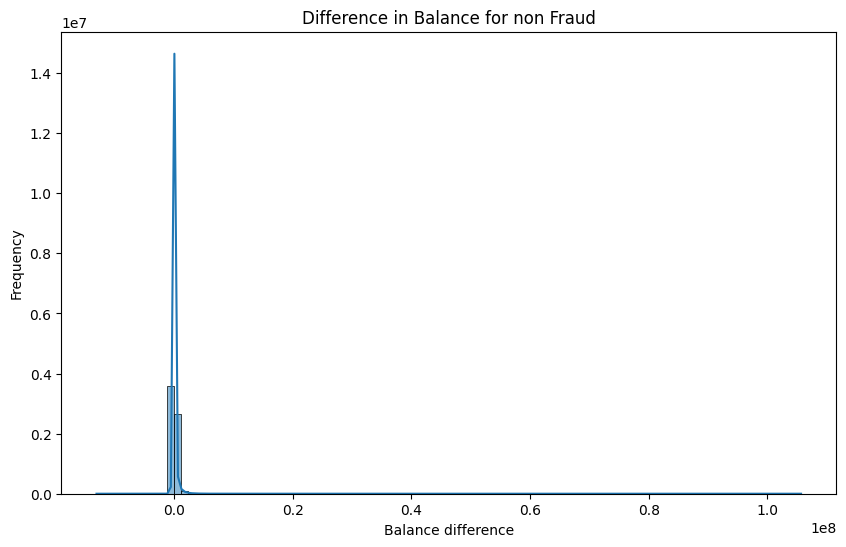

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(non_fraud_subset_dest['diffBalanceDest'], bins=100, kde=True)
plt.title('Difference in Balance for non Fraud')
plt.xlabel('Balance difference')
plt.ylabel('Frequency')
plt.show()

### Name Origin

In [34]:
subset_orig_dest = df[['nameOrig', 'nameDest', 'isFraud']].copy()
subset_orig_dest

,nameOrig,nameDest,isFraud
0,C1231006815,M1979787155,0
1,C1666544295,M2044282225,0
2,C1305486145,C553264065,1
3,C840083671,C38997010,1
4,C2048537720,M1230701703,0
...,...,...,...
6362615,C786484425,C776919290,1
6362616,C1529008245,C1881841831,1
6362617,C1162922333,C1365125890,1
6362618,C1685995037,C2080388513,1


In [35]:
# Group by nameOrig
nameorig_counts = subset_orig_dest.groupby('nameOrig').size()
nameorig_counts


nameOrig
C1000000639    1
C1000001337    1
C1000001725    1
C1000002591    1
C1000003372    1
              ..
C999996999     1
C999998175     1
C999999254     1
C999999614     1
C999999784     1
Length: 6353307, dtype: int64

In [36]:
# Get the nameOrig with occurence > 1 
nameorig_common = nameorig_counts[nameorig_counts > 1]
subset_nameorig_repeated = data[data['nameOrig'].isin(nameorig_common.index)]

Can we find users in the origin with mixed fraudulent and not fraudulent behaviour? Are they only doing fraud? 

In [37]:
fraudulent = subset_nameorig_repeated[subset_nameorig_repeated['isFraud'] == 1]['nameOrig'].unique()
non_fraudulent = subset_nameorig_repeated[subset_nameorig_repeated['isFraud'] == 0]['nameOrig'].unique()

common_fraud_nonfraud = np.intersect1d(fraudulent, non_fraudulent)
common_fraud_nonfraud

array(['C1015856166', 'C1044518032', 'C10982843', 'C1118399210',
       'C1127304441', 'C1191696703', 'C1498185758', 'C1627918307',
       'C171834973', 'C1851065642', 'C1863683348', 'C1882162040',
       'C1885333477', 'C1899367925', 'C2004363483', 'C357911107',
       'C431038121', 'C432562518', 'C471097879', 'C483009518',
       'C570470570', 'C635739031', 'C686187434', 'C803411135',
       'C812001868', 'C850961884', 'C876181265', 'C929585215'],
      dtype=object)

In [38]:
fraud_nonfraud_in_orig = data[data['nameOrig'].isin(common_fraud_nonfraud)].sort_values(by = 'nameOrig', ascending = True).reset_index(drop = True)
fraud_nonfraud_in_orig.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range
0,257,PAYMENT,2496.73,C1015856166,0.00,0.00,M183948217,0.00,0.00,0,1.000-10.000
1,453,CASH_OUT,2600970.32,C1015856166,2600970.32,0.00,C1424612838,2111795.89,4712766.22,1,1.000.000-10.000.000
2,19,CASH_IN,78603.46,C1044518032,1592298.26,1670901.72,C1544000930,156378.24,0.00,0,10.000-100.000
3,388,CASH_OUT,20393.12,C1044518032,20393.12,0.00,C1479987881,293446.62,313839.74,1,10.000-100.000
4,335,PAYMENT,5538.46,C10982843,29270.00,23731.54,M1708468225,0.00,0.00,0,1.000-10.000


Observations:

There is a very small amount of account data that shares fraudulent and non-fraudulent transactions. The only pattern observed is that every account has one fraudulent and one non-fraudulent transaction. Further analysis could be done here as long as we continue getting data to understand the behavior of these "hybrid" accounts

In [39]:
two_times_nameorig = nameorig_counts[nameorig_counts == 2]
subset_data_two_times = data[data['nameOrig'].isin(two_times_nameorig.index)]
subset_two_data_filtered = subset_data_two_times[~subset_data_two_times['nameOrig'].isin(common_fraud_nonfraud)].sort_values(by = 'nameOrig', ascending = True).reset_index(drop = True)
subset_two_data_filtered


,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range
0,254,CASH_IN,21813.13,C100025963,51809.00,73622.13,C1702915472,1657470.21,1635657.07,0,10.000-100.000
1,277,CASH_IN,68949.69,C100025963,797.00,69746.69,C1615713927,312817.27,243867.58,0,10.000-100.000
2,352,CASH_IN,146953.48,C1000442951,8737581.06,8884534.54,C642896648,596519.76,449566.28,0,100.000-1.000.000
3,15,CASH_OUT,44373.09,C1000442951,57101.00,12727.91,C994420111,83181.14,0.00,0,10.000-100.000
4,285,CASH_OUT,188876.87,C1000947901,0.00,0.00,C244769530,639830.17,828707.04,0,100.000-1.000.000
...,...,...,...,...,...,...,...,...,...,...,...
18505,209,CASH_OUT,165724.25,C999849840,21.00,0.00,C885377382,2526597.36,2692321.61,0,100.000-1.000.000
18506,156,CASH_OUT,170525.30,C999951360,0.00,0.00,C728588351,212287.42,382812.72,0,100.000-1.000.000
18507,202,CASH_OUT,73863.12,C999951360,0.00,0.00,C2035259819,477842.77,551705.88,0,10.000-100.000
18508,300,CASH_OUT,180065.16,C999972841,0.00,0.00,C1934233468,951897.18,1131962.34,0,100.000-1.000.000


In [40]:
subset_two_data_filtered.query('isFraud == 1')

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range


In [41]:
three_times_nameorig = nameorig_counts[nameorig_counts == 3]
subset_data_three_times = data[data['nameOrig'].isin(three_times_nameorig.index)].sort_values(by = 'nameOrig', ascending = True).reset_index(drop = True)
subset_data_three_times.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range
0,17,PAYMENT,5530.99,C1065307291,819637.87,814106.88,M1175397032,0.00,0.00,0,1.000-10.000
1,347,PAYMENT,19717.82,C1065307291,0.00,0.00,M2131079968,0.00,0.00,0,10.000-100.000
2,162,CASH_IN,88230.47,C1065307291,38128.00,126358.47,C1154752493,0.00,0.00,0,10.000-100.000
3,596,CASH_IN,113062.25,C1462946854,10580.00,123642.25,C569031032,538446.03,425383.78,0,100.000-1.000.000
4,514,CASH_IN,34253.45,C1462946854,1643662.56,1677916.01,C1393447203,130343.84,96090.39,0,10.000-100.000


In [42]:
subset_data_three_times.query('isFraud == 1')

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range


Observations:

The remaining commonly used accounts (more than two times) only have non fraudulent transactions

### Name Destination

In [43]:
# Group by nameOrig
namedest_counts = subset_orig_dest.groupby('nameOrig').size()
namedest_counts

nameOrig
C1000000639    1
C1000001337    1
C1000001725    1
C1000002591    1
C1000003372    1
              ..
C999996999     1
C999998175     1
C999999254     1
C999999614     1
C999999784     1
Length: 6353307, dtype: int64

In [44]:
# Get the nameOrig with occurence > 1 
namedest_common = namedest_counts[namedest_counts > 1]
subset_namedest_repeated = data[data['nameDest'].isin(namedest_common.index)]

Can we find users in the destination with mixed fraudulent and not fraudulent behaviour? Are they only doing fraud? 

In [45]:
fraudulent = subset_namedest_repeated[subset_namedest_repeated['isFraud'] == 1]['nameDest'].unique()
non_fraudulent = subset_namedest_repeated[subset_namedest_repeated['isFraud'] == 0]['nameDest'].unique()

common_fraud_nonfraud = np.intersect1d(fraudulent, non_fraudulent)
common_fraud_nonfraud

array([], dtype=object)

In [46]:
two_times_namedest = namedest_counts[namedest_counts == 2]
subset_data_two_times = data[data['nameDest'].isin(two_times_namedest.index)]
subset_data_two_times.query('isFraud == 1')

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range


In [47]:
three_times_namedest = namedest_counts[namedest_counts == 3]
subset_data_three_times = data[data['nameDest'].isin(three_times_namedest.index)].sort_values(by = 'nameDest', ascending = True).reset_index(drop = True)
subset_data_three_times.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range


Observations:

Merchants only have 1 time fraud occurence. That can happen if the client rejects the transaction thinking it's an invalid but it is valid. Maybe the forgot they bought an item by the time the transaction was done.

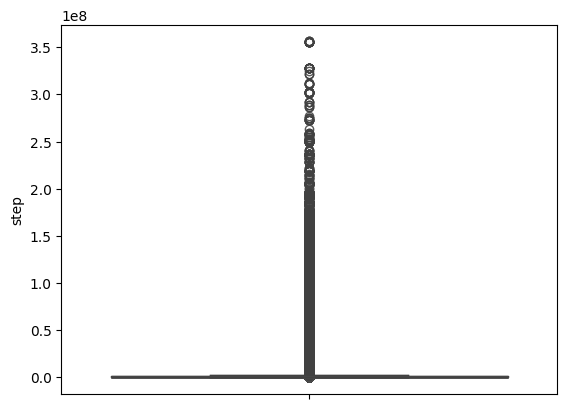

In [48]:
for col in numeric_cols:
    sns.boxplot(data = data, y=col)

## Outliers

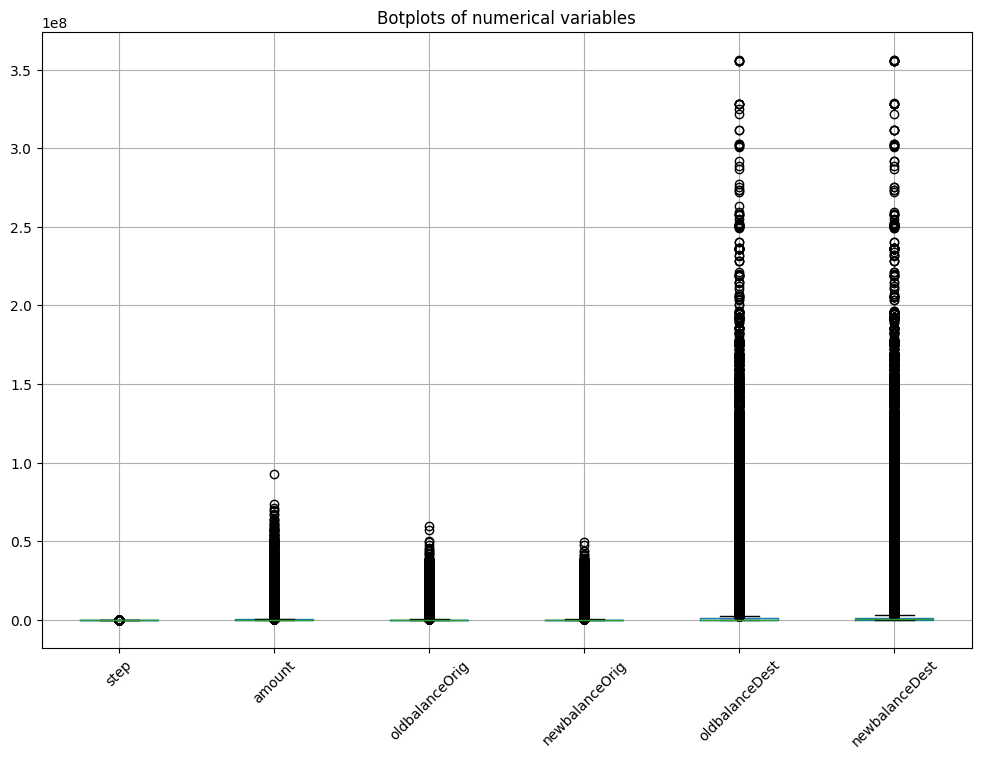

In [49]:
plt.figure(figsize=(12, 8))
data[numeric_cols].boxplot()
plt.title('Botplots of numerical variables')
plt.xticks(rotation=45)
plt.show()

In [50]:
# Select only numeric columns
numeric_columns = data.select_dtypes(include=['int64','float64'])

# Calculate quantiles for numeric columns
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# The rest of your code to detect outliers should remain the same
def detect_outliers(column):
    lower_bound = Q1[column] - 1.5 * IQR[column]
    upper_bound = Q3[column] + 1.5 * IQR[column]
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    if outliers.empty:
        return None, 0.0
    else:
        percentage = (len(outliers) / len(df)) * 100
        return column, percentage

columns_with_outliers = [detect_outliers(column) for column in numeric_columns.columns]
columns_with_outliers = [(column, percentage) for column, percentage in columns_with_outliers if column is not None]

for column, percentage in columns_with_outliers:
    print(f"Column: {column}, Percentage of outliers: {percentage:.2f}%")

Column: step, Percentage of outliers: 1.61%
Column: amount, Percentage of outliers: 5.31%
Column: oldbalanceOrig, Percentage of outliers: 17.49%
Column: newbalanceOrig, Percentage of outliers: 16.56%
Column: oldbalanceDest, Percentage of outliers: 12.36%
Column: newbalanceDest, Percentage of outliers: 11.61%
Column: isFraud, Percentage of outliers: 0.13%


## Correlation

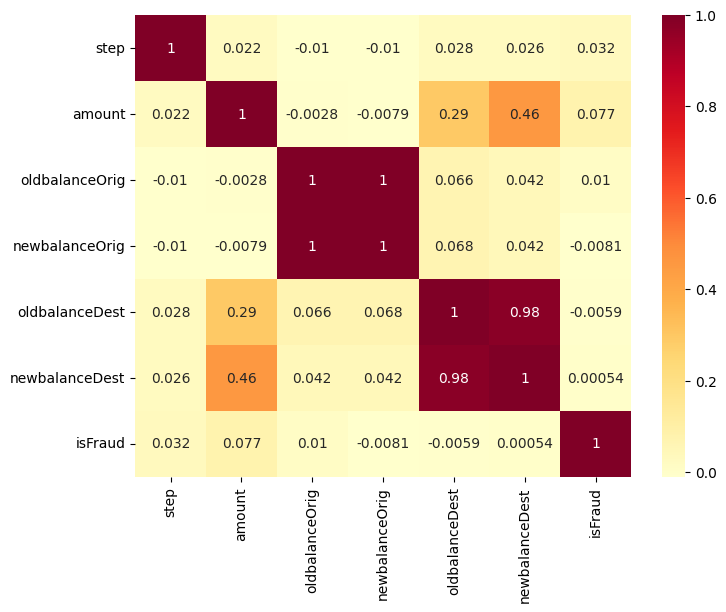

In [51]:
numeric_columns = data.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrRd')
plt.show()

Observations:

High multicollinearity between newbalanceDest and oldbalanceDest as we saw before. I will add diffBalanceDest and check corr 

In [52]:
data['diffBalanceDest'] = (data['newbalanceDest'] - data['oldbalanceDest']).round(2)

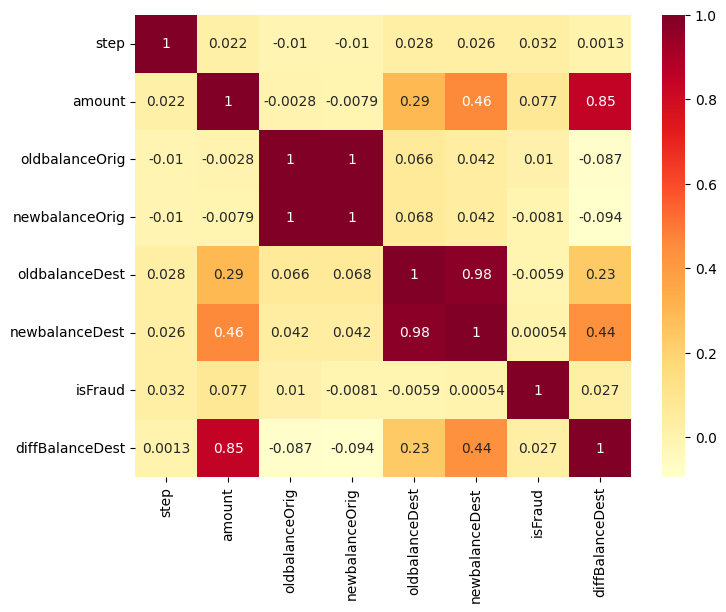

In [53]:
numeric_columns = data.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrRd')
plt.show()

In [54]:
data.query('nameOrig == "C1303719003"')

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range,diffBalanceDest
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,0-1.000,0.0


In [55]:
data.query('amount == 0').sort_values(by = 'nameDest')

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range,diffBalanceDest
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1,0-1.000,0.0
6362463,730,CASH_OUT,0.0,C2088151490,0.0,0.0,C1156763710,0.00,0.00,1,0-1.000,0.0
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0-1.000,0.0
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,0-1.000,0.0
6351226,702,CASH_OUT,0.0,C1461113533,0.0,0.0,C1382150537,107777.02,107777.02,1,0-1.000,0.0
6362461,730,CASH_OUT,0.0,C729003789,0.0,0.0,C1388096959,1008609.53,1008609.53,1,0-1.000,0.0
6362585,741,CASH_OUT,0.0,C312737633,0.0,0.0,C1400061387,267522.87,267522.87,1,0-1.000,0.0
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1,0-1.000,0.0
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,0-1.000,0.0
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,0-1.000,0.0


In [56]:
data.loc[df.duplicated(subset ='nameOrig')]

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range,diffBalanceDest
115385,11,PAYMENT,17670.78,C1709295811,488136.00,470465.22,M356415752,0.00,0.00,0,10.000-100.000,0.00
146871,12,CASH_IN,127216.34,C44568807,627.00,127843.34,C1768792843,95742.51,0.00,0,100.000-1.000.000,-95742.51
148517,12,PAYMENT,4611.17,C260230637,228156.00,223544.83,M350428813,0.00,0.00,0,1.000-10.000,0.00
196159,13,PAYMENT,2745.21,C745009740,0.00,0.00,M1554169249,0.00,0.00,0,1.000-10.000,0.00
208603,13,CASH_OUT,220681.45,C1842781381,70129.00,0.00,C1619574897,0.00,220681.45,0,100.000-1.000.000,220681.45
...,...,...,...,...,...,...,...,...,...,...,...,...
6359886,715,PAYMENT,3470.96,C876817986,38313.00,34842.04,M2021251796,0.00,0.00,0,1.000-10.000,0.00
6360204,715,TRANSFER,118688.81,C1313642079,110425.00,0.00,C927206109,0.00,118688.81,0,100.000-1.000.000,118688.81
6360821,717,CASH_OUT,40187.86,C188194996,69491.00,29303.14,C1210630308,679792.78,719980.63,0,10.000-100.000,40187.85
6361231,717,CASH_OUT,82899.05,C1170262181,253420.00,170520.95,C1991152940,61709.64,144608.69,0,10.000-100.000,82899.05


In [57]:
data.query('nameOrig == "C850961884"')

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range,diffBalanceDest
3579030,261,CASH_OUT,43540.18,C850961884,125501.97,81961.79,C1394340603,462839.58,506379.76,0,10.000-100.000,43540.18
6362423,727,CASH_OUT,263401.81,C850961884,263401.81,0.00,C1203132980,251586.80,514988.60,1,100.000-1.000.000,263401.80


In [58]:
data.loc[data.duplicated(subset =['nameOrig', 'nameDest'])]

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range,diffBalanceDest


Ideas:

- Check duplicated with query on names orig and dest that are Fraud == 1

In [59]:
skewness 

NameError: name 'skewness' is not defined

In [ ]:
kurtosis